## Set CME initial conditions

authors C. Möstl, A. J. Weiss, M. Bauer

https://gong2.nso.edu/oQR/zqs/

Currently uses the environment "cmesig" from https://github.com/cmoestl/cme_signatures

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.image import imread
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D

import datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd
import os

import copy

import sunpy
from sunpy.time import parse_time
import sunpy.data.sample
import sunpy.map
from sunpy.net.helioviewer import HelioviewerClient
from sunpy.map import Map
from sunpy.coordinates import frames
import drms
import glymur
import zeep

import astropy
import astropy.units as u

import astropy
import astropy.constants as const
from astropy.coordinates import SkyCoord


import heliopy
import heliopy.spice as spice
import heliopy.data.spice as spicedata


import urllib
import pfsspy
import pfsspy
from pfsspy import coords
from pfsspy import tracing


import glob


import heliosat


import py3dcore

#import astroquery

#import heliocats.plot as hp


import warnings
warnings.filterwarnings('ignore')

print(sns.__version__)

0.11.0


## simple speed calculation


In [86]:
#cor2 fov

r1=13*695000


#time in minutes from COR2 inner to outer
t1=90*60


speed=r1/t1

print('CME speed STEREO-A',speed)


#LASCO

CME speed STEREO-A 1673.148148148148


## ICMECAT



In [87]:
url='https://helioforecast.space/static/sync/icmecat/HELCATS_ICMECAT_v20.csv'
ic=pd.read_csv(url)
ic=ic.drop(columns='Unnamed: 0') #drop an extra index column

iwin=np.where(ic.sc_insitu=='Wind')[0]
ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]

i1au=np.sort(np.hstack([iwin,ista,istb]))
print('ICMECAT events near 1 AU',len(i1au))


ICMECAT events near 1 AU 555


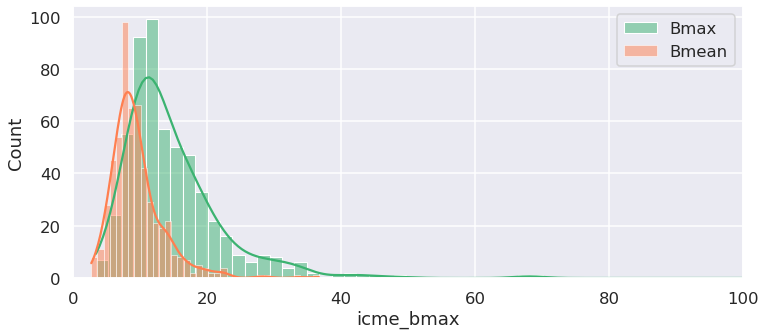

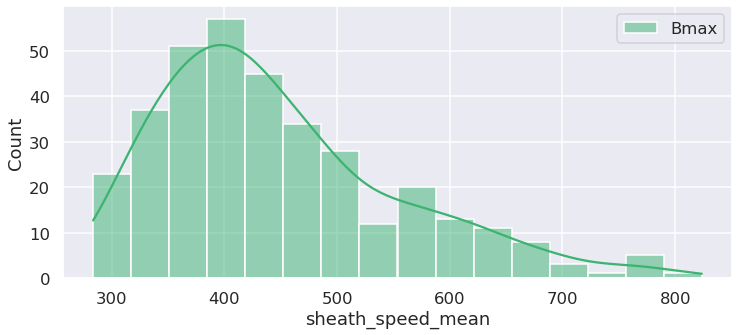

<Figure size 4500x2400 with 0 Axes>

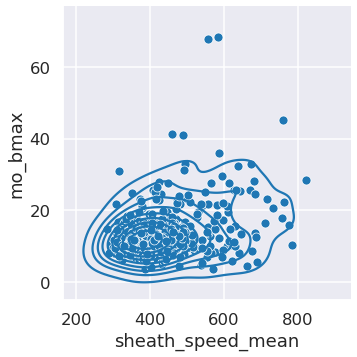

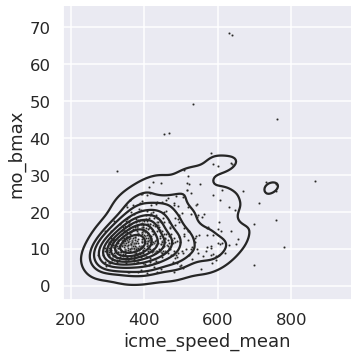

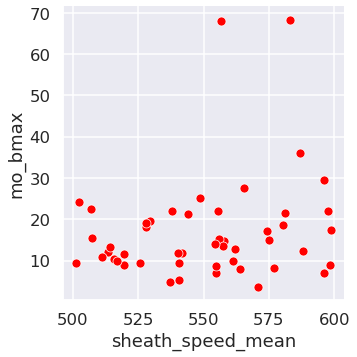

In [173]:
#make distribution plots
sns.set_style('darkgrid')

plt.figure(11,figsize=(12,5))
sns.histplot(ic.icme_bmax[i1au], label='Bmax',color='mediumseagreen',kde=True)
sns.histplot(ic.icme_bmean[i1au], label='Bmean',color='coral',alpha=0.5,kde=True)
plt.legend(loc=1)
plt.xlim(0,100)


plt.figure(12,figsize=(12,5))
sns.histplot(ic.sheath_speed_mean[i1au], label='Bmax',color='mediumseagreen',kde=True)
plt.legend(loc=1)



plt.figure(14,figsize=(15,8),dpi=300)
sns.relplot(x="sheath_speed_mean", y="mo_bmax", data=ic.loc[i1au,:]);
sns.kdeplot(x="sheath_speed_mean", y="mo_bmax", data=ic.loc[i1au,:]);


plt.figure(15,figsize=(15,8),dpi=300)
#sns.histplot(x="icme_speed_mean", y="mo_bmax", data=ic.loc[i1au,:],bins=50)
sns.relplot(x="icme_speed_mean", y="mo_bmax", data=ic.loc[i1au,:],s=5, color=".15")
sns.kdeplot(x="icme_speed_mean", y="mo_bmax", data=ic.loc[i1au,:],s=5, color=".15")


#plt.figure(16,figsize=(15,8),dpi=300)
i500=np.where(np.logical_and(ic.sheath_speed_mean > 500,ic.sheath_speed_mean < 600)==True)[0]
sns.relplot(ic.sheath_speed_mean[i500],ic.mo_bmax[i500],color='red')

## load NOAA data

download NOAA real time solar wind plasma and mag
2020_Dec_10_09_00 UTC

done


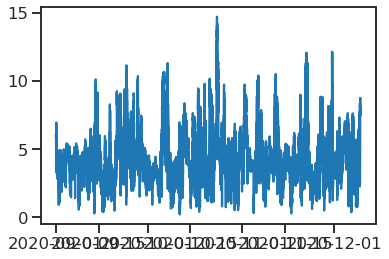

In [99]:
################## NOAA real time
################ load jsons


noaa_path='/nas/helio/data/noaa_rtsw/'
data_path='/nas/helio/data/insitu_python/'

print('download NOAA real time solar wind plasma and mag')
datestr=str(datetime.datetime.utcnow().strftime("%Y_%b_%d_%H_%M"))
print(datestr+' UTC')

plasma='http://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json'
mag='http://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json'

try: urllib.request.urlretrieve(plasma, noaa_path+'plasma-7-day_'+datestr+'.json')
except urllib.error.URLError as e:
  print(' ', plasma,' ',e.reason)

try: urllib.request.urlretrieve(mag, noaa_path+'mag-7-day_'+datestr+'.json')
except urllib.error.URLError as e:
  print(' ', mag,' ',e.reason)
  
print()



# my version:
#filenoaa='noaa_rtsw_jan_2020_now.p'
#if get_new_data: hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa)
#[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

#################### with Rachel Bailey's data from predstorm
#noaapath='/nas/helio/realcode/real/predstorm/data/rtsw_min_last100days.h5'
filenoaa='noaa_rtsw_last100days_now.p'
#if get_new_data: hd.save_noaa_rtsw_data_predstorm(data_path,noaapath,filenoaa)        
[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 
    
              
############### make 3 plots

#for ICMEs
#start=noaa.time[-1]-datetime.timedelta(days=3)
#end=datetime.datetime.utcnow() #noaa.time[-1]     
#hp.plot_insitu_update(noaa, start, end,'NOAA_RTSW_PREDSTORM_3days',plot_path,now=True)

print('done')
plt.plot(noaa.time,noaa.bt)

## 3DCORE

In [100]:
def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    ax.set_zlim([-view_radius, view_radius])
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)

    
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    
    
def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
def plot_circle(ax,dist,**kwargs):        

    thetac = np.linspace(0, 2 * np.pi, 100)
    xc=dist*np.sin(thetac)
    yc=dist*np.cos(thetac)
    zc=0
    ax.plot(xc,yc,zc,ls='--',color='black',lw=0.3,**kwargs)
      

def plot_satellite(ax,satpos1,**kwargs):

    xc=satpos1[0]*np.cos(np.radians(satpos1[1]))
    yc=satpos1[0]*np.sin(np.radians(satpos1[1]))
    zc=0
    #print(xc,yc,zc)
    ax.scatter3D(xc,yc,zc,**kwargs)

In [101]:
t_launch = datetime.datetime(2020, 12, 7, 18,0,0)



#2020 Dec 7: COR2 15 solar radii 18 UT


iparams_arr = np.array([[
    0,      # time offset
    0,    # l_1 (logitude) HEEQ
    0,#-20,    # l_2 (latitude)
    270,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    3,   # delta (cross-section aspect ratio)
    15,      # r_0 (initialization distance in solar radii)
    1670,    # v_0 (initial velocty in)
    4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    25,     # b_1au (magnetic field strength at 1au)
    0.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1)
tm1 =  t_launch + datetime.timedelta(days=3.5)
tm2 =  t_launch + datetime.timedelta(days=5.0)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

############# define synthetic satellite positions - semi-circle at 1 AU, from -90 to +90 longitude

lonstart=-90
lonstep=5
lonend=90

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=1.0
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 0.5 AU
satpos2=copy.deepcopy(satpos)
satpos2.r=0.5

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-90. -85. -80. -75. -70. -65. -60. -55. -50. -45. -40. -35. -30. -25.
 -20. -15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.
  50.  55.  60.  65.  70.  75.  80.  85.  90.]


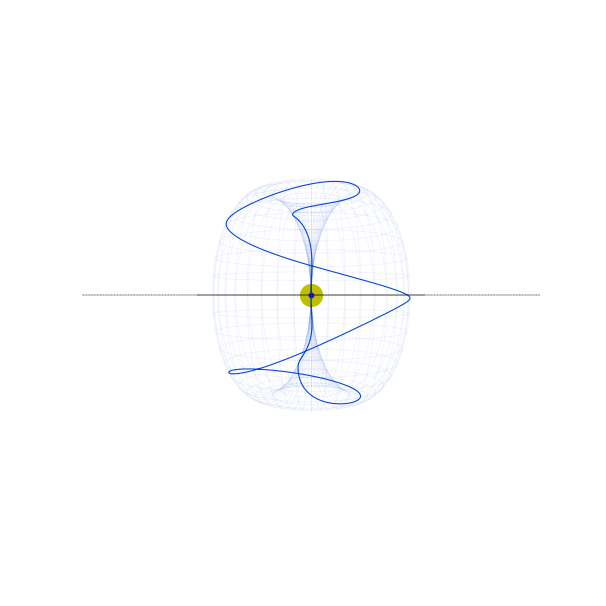

In [102]:
#use either 
#%matplotlib 
#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#%matplotlib inline


sns.set_context("talk")     
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.8)
#in other planes
#plot_configure(ax, view_azim=0, view_elev=90, view_radius=0.7)
#plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.6)


########## 3dcore plots
#plot_3dcore(ax, model_obj, tm0, color=c1)
#plot_3dcore_field(ax, model_obj, color=c1, step_size=0.005, lw=1.1, ls="-",q0=np.array([1, .1, np.pi/2]))

plot_3dcore(ax, model_obj, tm1, color=c2)
plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")

############# satellite plots
#plot_traj(ax, "Earth", tm1, frame="HEEQ", color=c1)
  
    
#for i in np.arange(0,len(satpos)):
#    plot_satellite(ax,satpos[i],color='black',alpha=0.9)    
#    plot_satellite(ax,satpos2[i],color='red',alpha=0.9)

plot_satellite(ax,satpos[18],color='blue',alpha=0.9)



##########cosmetics
#approximate Sun Earth line
ax.plot([0,1],[0,0],[0,0],ls='-',color='black',lw=0.3)

plot_circle(ax,0.5)
plot_circle(ax,1.0)

#plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
#plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

plt.tight_layout()

#plt.savefig('results/initial_test.pdf')
plt.savefig('results/initial_test.png', dpi=100)

In [103]:
def measure(obj, satpos1, t0, t1, frame="HEEQ", bframe="HEE", satparams=None):
    
    #print(obj)
    print('input')
    print(t0,' / ', t1, frame, bframe)
    
    #if satparams:
    #    inst = getattr(heliosat, sat)(satparams)
    #else:
    #    inst = getattr(heliosat, sat)()        
    #print(inst)    
    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]    
    #position of spacecraft
    #o_s = inst.trajectory(t_s, frame=frame)
    
    #time resolution in hours
    res_in_days=1/24.    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    print('data points',len(t_s))
    
    #generate position from satpos - always constant
    o_s=np.zeros([len(t_s),3])
    o_s[:,0]=satpos1[0]   #R in AU 
    o_s[:,1]=np.radians(satpos1[1]) #longitude
    o_s[:,2]=np.radians(satpos1[2]) #latitude

    #print(t_s)
    #print(o_s)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b, o_s




current satpos measured is  18
(1., 0., 0.)
input
2020-12-08 06:00:00  /  2020-12-26 06:00:00 HEEQ HEE
data points 432
took  0.061   seconds



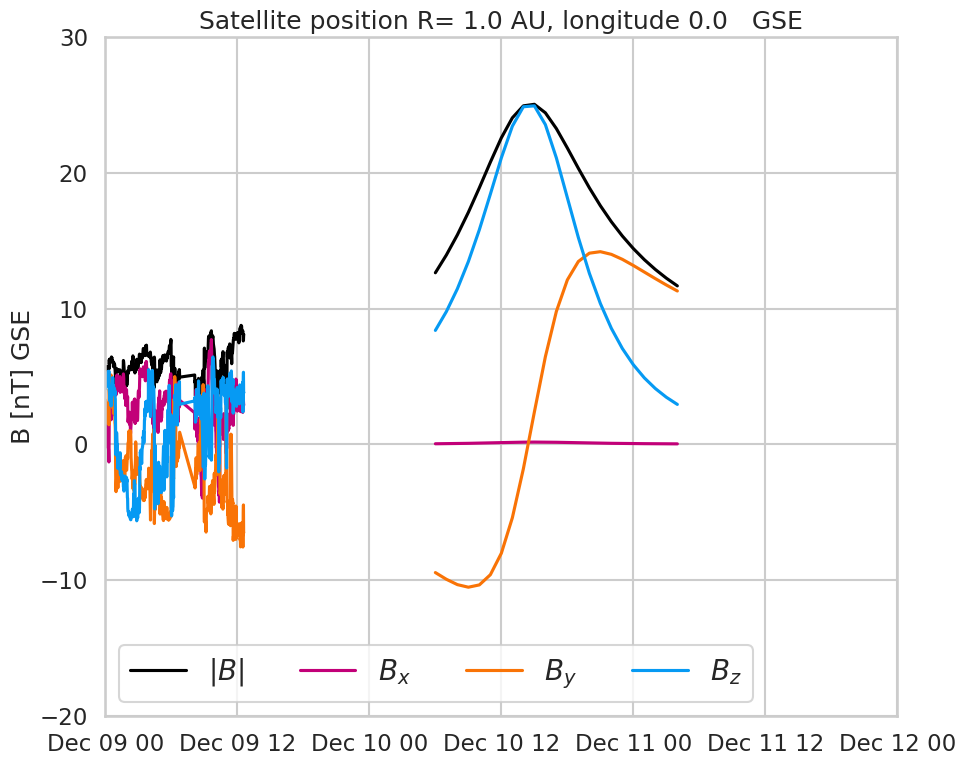

In [109]:
'''
t_launch = datetime.datetime(2020, 1, 1, 0)

iparams_arr = np.array([[
    0,      # time offset
    0,    # l_1 (logitude) HEEQ
    0,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    5,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    500,    # v_0 (initial velocty in)
    -1.0,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    15,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)
'''

############################### measure magnetic field
print()
start=time.time()

#18 is middle
satposindex=18
print('current satpos measured is ', satposindex)
print(satpos[satposindex])

#t0, btot0, bxyz0, os = measure(model_obj, satpos[6], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=20))
t1, btot1, bxyz1, os1 = measure(model_obj, satpos[satposindex], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=15))
#t2, btot2, bxyz2, os = measure(model_obj, satpos[30], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=20))
print('took ', np.round(time.time()-start,3), '  seconds')
print()
#print(t1)
#print(os1)


################################################
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(10, 8),dpi=100)

ax1 = fig.add_subplot(111)
ax1.set_title('Satellite position R= 1.0 AU, longitude '+str(satpos.lon[satposindex])+'   GSE')

ax1.plot(t1, btot1, color=cbt, label="$|B|$")
ax1.plot(t1, -bxyz1[:, 0], color=cbx, label="$B_x$")
ax1.plot(t1, -bxyz1[:, 1], color=cby, label="$B_y$")
ax1.plot(t1, bxyz1[:, 2], color=cbz, label="$B_z$")

ax1.legend(loc="lower left", fontsize=20,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H'))
ax1.set_ylabel('B [nT] GSE')
plt.ylim(-20,30)
plt.xlim(datetime.datetime(2020,12,9,0,0,0),datetime.datetime(2020,12,12,0,0,0))


ax1.plot(noaa.time,noaa.bt,color=cbt)
ax1.plot(noaa.time,noaa.bx,color=cbx)
ax1.plot(noaa.time,noaa.by,color=cby)
ax1.plot(noaa.time,noaa.bz,color=cbz)
plt.tight_layout()

#plt.savefig('results/initial_test_measure_1.pdf', dpi=300)
plt.savefig('results/initial_test_measure_1.png', dpi=100)



## Images

In [2]:
hv = HelioviewerClient()
#look at data sources
#hv.get_data_sources()

#https://docs.sunpy.org/en/latest/guide/acquiring_data/helioviewer.html


############################### LASCO

# copy this in the console to get a list of viable data sources
#hv.get_data_sources())

t1='2012/07/23 04:00:00'

#file = hv.download_jp2('2020/08/01', observatory="SDO", instrument="AIA",    measurement="304") 
#file = hv.download_jp2('2017/05/23', observatory="STEREO_A", instrument="SECCHI", detector='COR2'  ,  measurement="white-light") 
#file = hv.download_jp2('2012/07/23 04:00:00', observatory="SOHO", instrument="LASCO", detector='C3'  ,  measurement="white-light") 
file = hv.download_jp2(t1, observatory="SOHO", instrument="LASCO", detector='C3',  measurement="white-light") 


las = Map(file)  

lasrot = las.rotate(angle=5 * u.deg)

t_launch = datetime.datetime(2012, 7,23, 0)

iparams_arr = np.array([[
    0,      # time offset
    90,    # l_1 (logitude) HEEQ
    20,    # l_2 (latitude)
    60,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    5,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    600,    # v_0 (initial velocty in)
    -4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    20,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=0.1)
tm1 =  t_launch + datetime.timedelta(days=0.2)
tm2 =  t_launch + datetime.timedelta(days=0.3)
tm3 =  t_launch + datetime.timedelta(days=0.4)
tm4 =  t_launch + datetime.timedelta(days=0.5)

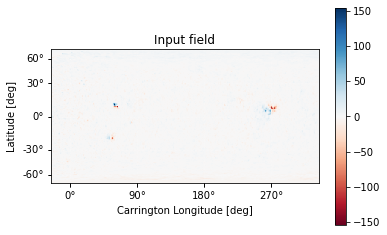

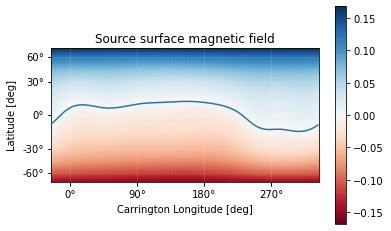

In [4]:
#pfsspy
#190310t0014gong.fits

'''
def get_gong_map(file):
    """
    Automatically download and unzip a sample GONG synoptic map.
    """
    if not os.path.exists(file) and not os.path.exists(file):
        import urllib.request
        urllib.request.urlretrieve(
            'https://gong2.nso.edu/oQR/zqs/201903/mrzqs190310/mrzqs190310t0014c2215_333.fits.gz',
            'file+'.gz)

    if not os.path.exists(file):
        import gzip
        with gzip.open(file+'.gz', 'rb') as f:
            with open(file, 'wb') as g:
                g.write(f.read())

    return file


    
file='200920t0014gong.fits'

gong_fname = get_gong_map(file)

'''

def set_axes_lims(ax):
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 180)

    


def get_gong_map():
    """
    Automatically download and unzip a sample GONG synoptic map.
    """
    if not os.path.exists('190310t0014gong.fits') and not os.path.exists('190310t0014gong.fits.gz'):
        import urllib.request
        urllib.request.urlretrieve(
            'https://gong2.nso.edu/oQR/zqs/201903/mrzqs190310/mrzqs190310t0014c2215_333.fits.gz',
            '190310t0014gong.fits.gz')

    if not os.path.exists('190310t0014gong.fits'):
        import gzip
        with gzip.open('190310t0014gong.fits.gz', 'rb') as f:
            with open('190310t0014gong.fits', 'wb') as g:
                g.write(f.read())

    return '190310t0014gong.fits'

gong_fname = get_gong_map()


gong_map = sunpy.map.Map(gong_fname)
# Remove the mean
gong_map = sunpy.map.Map(gong_map.data - np.mean(gong_map.data), gong_map.meta)

nrho = 35
rss = 2.5


input = pfsspy.Input(gong_map, nrho, rss)


    
    
m = input.map
fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()
ax.set_title('Input field')
set_axes_lims(ax)


output = pfsspy.pfss(input)


ss_br = output.source_surface_br
# Create the figure and axes
fig = plt.figure()
ax = plt.subplot(projection=ss_br)

# Plot the source surface map
ss_br.plot()
# Plot the polarity inversion line
ax.plot_coord(output.source_surface_pils[0])
# Plot formatting
plt.colorbar()
ax.set_title('Source surface magnetic field')
set_axes_lims(ax)





coordinates of observer  <Helioprojective Frame (obstime=2012-07-23T03:54:07.231, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2012-07-23T03:54:07.231): (lon, lat, radius) in (deg, deg, AU)
    (0., 5.10195203, 1.01592031)>)>
WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 560.3442438414609  577.0040330078932  
PC1_1 PC1_2  : 0.9999990215655803  0.0013988809392355113  
PC2_1 PC2_2  : -0.0013988809392355183  0.9999990215655803  
CDELT : 0.015555555555555555  0.015555555555555555  
NAXIS : 1024  1024


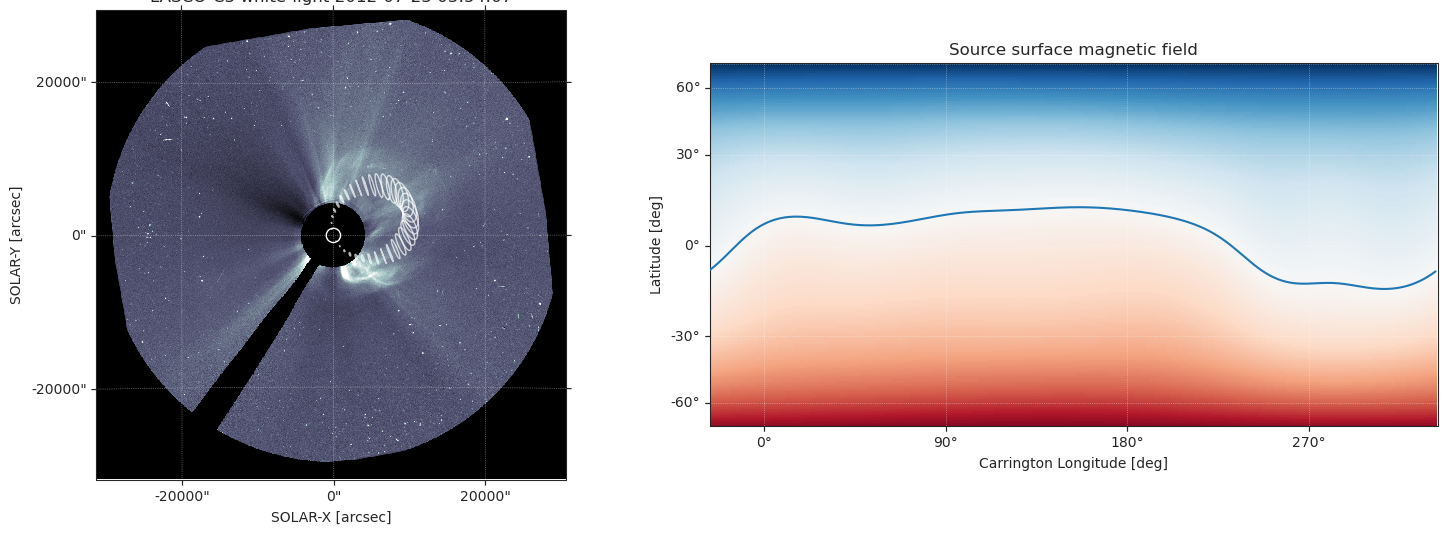

In [5]:

%matplotlib inline

sns.set_style('white')
fig = plt.figure(1,figsize=(15, 5),dpi=100)

################################### plot 1

ax1 = plt.subplot(121, projection=lasrot)

print('coordinates of observer ',lasrot.coordinate_frame)
print(lasrot.wcs)

#plot image
lasrot.plot()
lasrot.draw_limb()
#plt.colorbar()

model_obj.propagate(tm0)

wf_model = model_obj.visualize_wireframe(index=0)

mc= SkyCoord(wf_model.T[0,:,:]*u.AU, wf_model.T[1,:,:]*u.AU, wf_model.T[2,:,:]*u.AU, frame='heliographic_stonyhurst',representation_type='cartesian')

ax1.plot_coord(mc,color='white',linewidth=1,alpha=0.7)

################################## plot 2


ax2 = plt.subplot(122,projection=ss_br)


ss_br = output.source_surface_br
# Plot the source surface map
ss_br.plot()
# Plot the polarity inversion line
ax2.plot_coord(output.source_surface_pils[0])
# Plot formatting
#plt.colorbar()
ax2.set_title('Source surface magnetic field')
set_axes_lims(ax2)

plt.tight_layout()

plt.savefig('results/cmeinit/lasco_3dcore_pfss.png')